# SetFit Model Optimization with Intel Extension for Transformers

## Setup Development Environment

In [ ]:
!pip install intel-extension-for-transformers neural-compressor==1.14.2 setfit datasets torch wandb matplotlib onnx onnxruntime onnxruntime_extensions optimum[onnxruntime]==1.5.0 numpy==1.22.0

## SetFit Models on AG News Dataset

In [2]:
import numpy as np
import torch
from datasets import load_metric
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation, util
from time import perf_counter

/home2/xinyuye/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

In [3]:
from datasets import load_dataset
agnews = load_dataset("ag_news")
test_dataset = agnews["test"]
topics = agnews["test"].features["label"]

Found cached dataset ag_news (/home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 505.92it/s]


### Creating a Performance Benchmark

In [4]:
accuracy_score = load_metric("accuracy")

class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds = self.model.predict(self.dataset["text"])
        labels = self.dataset["label"]
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.4f}")
        return accuracy

    def compute_size(self):
        state_dict = self.model.model_body.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_model(self, query="Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."):
        latencies = []
        # Warmup
        for i in range(10):
            _ = self.model([query])
        # Timed run
        for i in range(100):
            start_time = perf_counter()
            _ = self.model([query])
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.compute_accuracy())
        metrics[self.optim_type].update(self.time_model())
        return metrics

/tmp/ipykernel_274253/2441132276.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


### Train MPNet - The teacher model

In [5]:
num_classes = 4
train_dataset = agnews["train"].shuffle(seed=0).select(range(8 * num_classes))

Loading cached shuffled indices for dataset at /home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-14835fe84e596ed4.arrow


In [6]:
from intel_extension_for_transformers.setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss

# Load a SetFit model from Hub
model_id = "paraphrase-mpnet-base-v2"
model = SetFitModel.from_pretrained(model_id)

# Create trainer
teacher_trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for constrastive learning
)

# Train and evaluate
teacher_trainer.train()
metrics = teacher_trainer.evaluate()

print(f"model used: {model_id}")
print(f"train dataset: {len(train_dataset)} samples")
print(f"accuracy: {metrics['accuracy']}")

MPNet_teacher_model = teacher_trainer.model.model_body

config.json not found in HuggingFace Hub
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1280
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 16
Iteration:  40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 32/80 [00:33<00:49,  1.04s/it]


Iteration:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 68/80 [01:10<00:12,  1.03s/it]


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:22<00:00, 82.55s/it]
***** Running evaluation *****


model used: paraphrase-mpnet-base-v2
train dataset: 32 samples
accuracy: 0.8405263157894737


In [7]:
optim_type = "MPNet_teacher FP32 Torch"
pb = PerformanceBenchmark(
    model=teacher_trainer.model, dataset=test_dataset, optim_type=optim_type
)
perf_metrics = pb.run_benchmark()

Model size (MB) - 417.73
Accuracy on test set - 0.8405
Average latency (ms) - 25.16 +\- 0.07


### Train mini_LM_L3 - The student model

In [8]:
from intel_extension_for_transformers.setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss

# Load a SetFit model from Hub
model_id = 'paraphrase-MiniLM-L3-v2'
model = SetFitModel.from_pretrained(model_id)

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for constrastive learning
)

# Train and evaluate
trainer.train()
metrics = trainer.evaluate()

print(f"model used: {model_id}")
print(f"train dataset: {len(train_dataset)} samples")
print(f"accuracy: {metrics['accuracy']}")

MiniLM_L3_model = trainer.model.model_body

config.json not found in HuggingFace Hub
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1280
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 16
Iteration:  40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 32/80 [00:05<00:07,  6.33it/s]


Iteration:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 68/80 [00:10<00:01,  6.32it/s]


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.66s/it]
***** Running evaluation *****


model used: paraphrase-MiniLM-L3-v2
train dataset: 32 samples
accuracy: 0.7132894736842105


In [9]:
optim_type = "MiniLM_L3_student FP32 Torch"
pb = PerformanceBenchmark(
    model=trainer.model, dataset=test_dataset, optim_type=optim_type
)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 66.36
Accuracy on test set - 0.7133
Average latency (ms) - 5.38 +\- 0.40


### SetFit distillation on the student model 

In [10]:
from intel_extension_for_transformers.setfit import SetFitModel, SetFitTrainer, DistillationSetFitTrainer

train_dataset_student = agnews["train"].shuffle(seed=0).select(range(1000))

#Distill
student_model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L3-v2")
teacher_model = teacher_trainer.model
student_trainer = DistillationSetFitTrainer(teacher_model=teacher_model, train_dataset=train_dataset_student, student_model=student_model, eval_dataset=test_dataset, loss_class=CosineSimilarityLoss, metric="accuracy", batch_size=16, num_iterations=20, num_epochs=1)

# Student Train and evaluate
student_trainer.train()
metrics = student_trainer.evaluate()
print("Student results: ", metrics)
MiniLM_L3_distilled_model = student_trainer.model.model_body
MiniLM_L3_distilled_model.save('MiniLM_L3_distilled')

Loading cached shuffled indices for dataset at /home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-14835fe84e596ed4.arrow
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 40000
  Num epochs = 1
  Total optimization steps = 2500
  Total train batch size = 16
Iteration:   1%|██▏                                                                                                                                                                          | 31/2500 [00:05<07:59,  5.15it/s]


Iteration:   3%|████▋                                                                                                                                                                        | 67/2500 [00:12<07:32,  5.38it/s]


Iteration:   4%|███████                                                                                                                                                                     | 103/2500 [00:19<07:35,  5.26it/s]


Iteration:   6%|█████████▌                                                                                                                                                                  | 139/2500 [00:26<07:13,  5.44it/s]


Iteration:   7%|████████████                                                                                                                                                                | 175/2500 [00:32<07:18,  5.31it/s]


Iteration:   8%|██████████████▌                                                                                                                                                             | 211/2500 [00:39<07:08,  5.34it/s]


Iteration:  10%|████████████████▉                                                                                                                                                           | 247/2500 [00:46<07:11,  5.23it/s]


Iteration:  11%|███████████████████▍                                                                                                                                                        | 283/2500 [00:53<06:49,  5.42it/s]


Iteration:  13%|█████████████████████▉                                                                                                                                                      | 319/2500 [00:59<06:49,  5.32it/s]


Iteration:  14%|████████████████████████▍                                                                                                                                                   | 355/2500 [01:06<06:36,  5.41it/s]


Iteration:  16%|██████████████████████████▉                                                                                                                                                 | 391/2500 [01:13<06:24,  5.49it/s]


Iteration:  17%|█████████████████████████████▍                                                                                                                                              | 427/2500 [01:19<06:17,  5.49it/s]


Iteration:  19%|███████████████████████████████▊                                                                                                                                            | 463/2500 [01:26<06:23,  5.32it/s]


Iteration:  20%|██████████████████████████████████▎                                                                                                                                         | 499/2500 [01:33<06:14,  5.35it/s]


Iteration:  21%|████████████████████████████████████▊                                                                                                                                       | 535/2500 [01:39<06:02,  5.42it/s]


Iteration:  23%|███████████████████████████████████████▎                                                                                                                                    | 571/2500 [01:46<05:54,  5.45it/s]


Iteration:  24%|█████████████████████████████████████████▊                                                                                                                                  | 607/2500 [01:53<05:53,  5.36it/s]


Iteration:  26%|████████████████████████████████████████████▏                                                                                                                               | 643/2500 [01:59<05:47,  5.34it/s]


Iteration:  27%|██████████████████████████████████████████████▋                                                                                                                             | 679/2500 [02:06<05:38,  5.38it/s]


Iteration:  29%|█████████████████████████████████████████████████▏                                                                                                                          | 715/2500 [02:13<05:32,  5.37it/s]


Iteration:  30%|███████████████████████████████████████████████████▋                                                                                                                        | 751/2500 [02:19<05:29,  5.31it/s]


Iteration:  31%|██████████████████████████████████████████████████████▏                                                                                                                     | 787/2500 [02:26<05:21,  5.33it/s]


Iteration:  33%|████████████████████████████████████████████████████████▌                                                                                                                   | 823/2500 [02:33<05:13,  5.35it/s]


Iteration:  34%|███████████████████████████████████████████████████████████                                                                                                                 | 859/2500 [02:40<05:13,  5.24it/s]


Iteration:  36%|█████████████████████████████████████████████████████████████▌                                                                                                              | 895/2500 [02:46<04:53,  5.47it/s]


Iteration:  37%|████████████████████████████████████████████████████████████████                                                                                                            | 931/2500 [02:53<04:55,  5.32it/s]


Iteration:  39%|██████████████████████████████████████████████████████████████████▌                                                                                                         | 967/2500 [03:00<04:49,  5.29it/s]


Iteration:  40%|████████████████████████████████████████████████████████████████████▌                                                                                                      | 1003/2500 [03:07<04:44,  5.26it/s]


Iteration:  42%|███████████████████████████████████████████████████████████████████████                                                                                                    | 1039/2500 [03:13<04:33,  5.35it/s]


Iteration:  43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1075/2500 [03:20<04:24,  5.39it/s]


Iteration:  44%|███████████████████████████████████████████████████████████████████████████▉                                                                                               | 1111/2500 [03:27<04:28,  5.18it/s]


Iteration:  46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1147/2500 [03:34<04:11,  5.39it/s]


Iteration:  47%|████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1183/2500 [03:40<04:07,  5.32it/s]


Iteration:  49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1219/2500 [03:47<03:56,  5.42it/s]


Iteration:  50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1255/2500 [03:54<03:49,  5.42it/s]


Iteration:  52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1291/2500 [04:00<03:43,  5.41it/s]


Iteration:  53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1327/2500 [04:07<03:48,  5.13it/s]


Iteration:  55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1363/2500 [04:14<03:29,  5.42it/s]


Iteration:  56%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1399/2500 [04:21<03:23,  5.41it/s]


Iteration:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1435/2500 [04:27<03:15,  5.44it/s]


Iteration:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1471/2500 [04:34<03:11,  5.37it/s]


Iteration:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1507/2500 [04:41<03:04,  5.39it/s]


Iteration:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1543/2500 [04:48<02:58,  5.37it/s]


Iteration:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1579/2500 [04:54<02:48,  5.46it/s]


Iteration:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1615/2500 [05:01<02:41,  5.49it/s]


Iteration:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1651/2500 [05:07<02:37,  5.39it/s]


Iteration:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1687/2500 [05:14<02:31,  5.36it/s]


Iteration:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1723/2500 [05:21<02:26,  5.31it/s]


Iteration:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1759/2500 [05:28<02:20,  5.26it/s]


Iteration:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1795/2500 [05:34<02:12,  5.31it/s]


Iteration:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1831/2500 [05:41<02:07,  5.27it/s]


Iteration:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1867/2500 [05:48<01:57,  5.40it/s]


Iteration:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1903/2500 [05:55<01:51,  5.35it/s]


Iteration:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1939/2500 [06:01<01:44,  5.38it/s]


Iteration:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1975/2500 [06:08<01:38,  5.32it/s]


Iteration:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2011/2500 [06:15<01:30,  5.38it/s]


Iteration:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2047/2500 [06:21<01:25,  5.32it/s]


Iteration:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2083/2500 [06:28<01:18,  5.29it/s]


Iteration:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2119/2500 [06:35<01:11,  5.35it/s]


Iteration:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2155/2500 [06:42<01:04,  5.36it/s]


Iteration:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2191/2500 [06:49<00:59,  5.16it/s]


Iteration:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2227/2500 [06:56<00:52,  5.22it/s]


Iteration:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2263/2500 [07:02<00:44,  5.28it/s]


Iteration:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2299/2500 [07:09<00:37,  5.30it/s]


Iteration:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2335/2500 [07:16<00:31,  5.31it/s]


Iteration:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2371/2500 [07:23<00:24,  5.30it/s]


Iteration:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2407/2500 [07:30<00:17,  5.23it/s]


Iteration:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2443/2500 [07:36<00:10,  5.26it/s]


Iteration:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2479/2500 [07:43<00:03,  5.41it/s]


Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [07:47<00:00, 467.47s/it]
***** Running evaluation *****


Student results:  {'accuracy': 0.8405263157894737}


In [11]:
optim_type = "MiniLM_L3_student_distilled FP32 Torch"
pb = PerformanceBenchmark(
    model=student_trainer.model, dataset=test_dataset, optim_type=optim_type
)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 66.36
Accuracy on test set - 0.8405
Average latency (ms) - 5.13 +\- 0.30


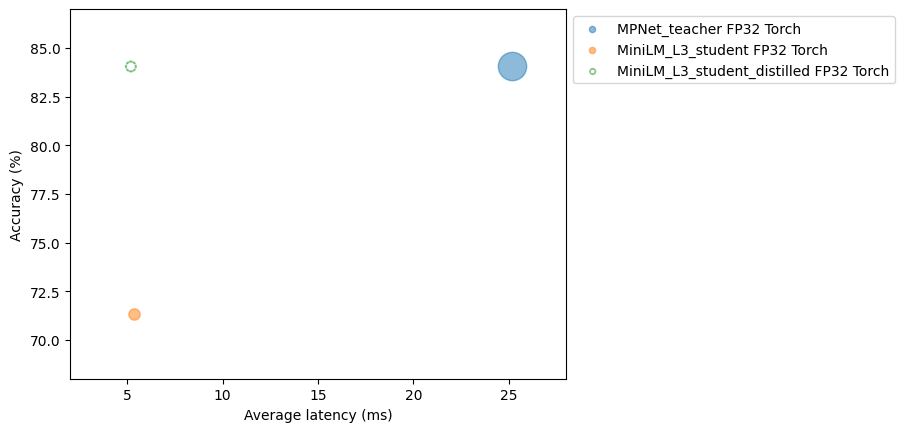

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    ys = [perf_metrics[k]["accuracy"]*100 for k in perf_metrics]
    plt.ylim(int(min(ys) - 3), int(max(ys) + 3))
    xs = [perf_metrics[k]["time_avg_ms"] for k in perf_metrics]
    plt.xlim(int(min(xs) - 3), int(max(xs) + 3))
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

## Optimizing SetFit Model with Intel Neural Compressor

 ### Convert PyTorch FP32 SetFit model to ONNX FP32 model

In [13]:
from optimum.onnxruntime import ORTModelForFeatureExtraction
from transformers import AutoTokenizer
from pathlib import Path

model_id = "MiniLM_L3_distilled"
onnx_path = Path("onnx")

# load vanilla transformers and convert to onnx
model = ORTModelForFeatureExtraction.from_pretrained(model_id, from_transformers=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# save onnx checkpoint and tokenizer
model.save_pretrained(onnx_path)
tokenizer.save_pretrained(onnx_path)

from optimum.onnxruntime import ORTOptimizer
from optimum.onnxruntime.configuration import OptimizationConfig

# create ORTOptimizer and define optimization configuration
optimizer = ORTOptimizer.from_pretrained(model)
optimization_config = OptimizationConfig(optimization_level=99) # enable all optimizations

# apply the optimization configuration to the model
optimizer.optimize(
    save_dir=onnx_path,
    optimization_config=optimization_config,
)

/home2/xinyuye/anaconda3/envs/py39/lib/python3.9/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
2023-02-17 14:59:51.026754630 [W:onnxruntime:, inference_session.cc:1458 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.


PosixPath('onnx')

### Quantize the SetFit model

In [14]:
def build_static_quant_yaml():
    yaml = """
model:
  name: bert
  framework: onnxrt_qlinearops

quantization:
  approach: post_training_static_quant
  calibration:
    sampling_size: 40

tuning:
  accuracy_criterion:
    relative: 0.01
  exit_policy:
    timeout: 0
  random_seed: 9527
    """
    with open('MiniLM_L3_ST_distilled_onnx_static.yaml', 'w', encoding="utf-8") as f:
        f.write(yaml)

def build_dynamic_quant_yaml():
    yaml = """
model:
  name: bert
  framework: onnxrt_integerops

quantization:
  approach: post_training_dynamic_quant

tuning:
  accuracy_criterion:
    relative: 0.01
  exit_policy:
    timeout: 0
  random_seed: 9527
    """
    with open('MiniLM_L3_ST_distilled_onnx_dynamic.yaml', 'w', encoding="utf-8") as f:
        f.write(yaml)

build_static_quant_yaml()
build_dynamic_quant_yaml()

In [15]:
import os
import onnx
import onnxruntime
from neural_compressor.experimental import Quantization, common
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModel,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    default_data_collator,
    set_seed,
)

raw_datasets = load_dataset("ag_news")
model_id = "MiniLM_L3_distilled"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id)

class OnnxSetFitModel:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.predictor = LogisticRegression(max_iter=200)

    def fit_predictor(self, embeddings, labels):
        self.predictor.fit(embeddings, labels)

    def predict(self, embeddings):
        return self.predictor.predict(embeddings)

    def forward(self, model_input):
        model_input = {k:model_input[k].numpy() for k in model_input}
        embedding = self.model.run([self.model.get_outputs()[0].name], model_input)[0]
        token_embeddings = torch.tensor(embedding)
        attention_mask = torch.tensor(model_input['attention_mask'])
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9, max=1e9).numpy()
        return embedding

    def __call__(self, inputs):
        model_input = self.tokenizer(
            inputs, padding=True, truncation=True, return_tensors="pt"
        )
        return self.predict(self.forward(model_input))

def preprocess_function(examples):
    # Tokenize the texts
    args = ((examples["text"],))
    result = tokenizer(*args, padding="max_length", max_length=128, truncation=True)
    result["label"] = examples["label"]
    return result

def compute_metrics(preds, labels):
    return (preds == labels).astype(np.float32).mean().item()

num_classes = 4
raw_datasets["train"] = raw_datasets["train"].shuffle(seed=0).select(range(8 * num_classes))
preprocessed_datasets = raw_datasets.map(preprocess_function, batched=True)
preprocessed_datasets = preprocessed_datasets.remove_columns(['text', ])

train_dataset = preprocessed_datasets["train"]
eval_dataset = preprocessed_datasets["test"]

training_args = TrainingArguments(output_dir='tmp')
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=default_data_collator
)

def eval_func(model):
    model = onnxruntime.InferenceSession(model.SerializeToString(), None)
    setfit_model = OnnxSetFitModel(model, tokenizer)
    def get_data(model, dataloader):
        embeddings = []
        labels = []
        for model_input in tqdm(dataloader):
            labels.append(model_input.pop('labels').numpy())
            embedding = model.forward(model_input)
            embedding = embedding.detach().cpu().numpy()
            embeddings.append(embedding)
        return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)
    # train logistic regressor
    embeddings, labels = get_data(setfit_model, trainer.get_train_dataloader())
    sgd = LogisticRegression(max_iter=200)
    sgd.fit(embeddings, labels)

    # evaluate
    embeddings, labels = get_data(setfit_model, trainer.get_eval_dataloader())
    y_pred_test_sgd = sgd.predict(embeddings)

    return compute_metrics(y_pred_test_sgd, labels)

class CalibrationDataset():
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = data.pop('label')
        return {k:data[k] for k in data}, label

    def __len__(self):
        return len(self.dataset)


model_input = "onnx/model_optimized.onnx"
onnx_int8_model_path = "onnx/MiniLM_L3_int8_static.onnx"
quantizer = Quantization("MiniLM_L3_ST_distilled_onnx_static.yaml")
quantizer.model = common.Model(model_input)
quantizer.eval_func = eval_func
quantizer.calib_dataloader = common.DataLoader(CalibrationDataset(train_dataset), 1)
q_model = quantizer()
q_model.save(onnx_int8_model_path)

onnx_int8_inc_dynamic_model_path = "onnx/MiniLM_L3_int8_dynamic.onnx"
quantizer = Quantization("MiniLM_L3_ST_distilled_onnx_dynamic.yaml")
quantizer.model = common.Model(model_input)
quantizer.eval_func = eval_func
q_model = quantizer()
q_model.save(onnx_int8_inc_dynamic_model_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-02-17 15:00:05 [WARNING] Found cached dataset ag_news (/home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 516.76it/s]
2023-02-17 15:00:05 [WARNING] Loading cached shuffled indices for dataset at /home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-14835fe84e596ed4.arrow
2023-02-17 15:00:05 [WARNING] Loading cached processed dataset at /home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-61129fe6d8cfe277.arrow
2023-02-17 15:00:05 [WARNING] Loading cached processed dataset at /home2/xinyuye/.cache/huggingface/datasets/ag_news/default

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Get FP32 model baseline.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:15<00:00, 60.38it/s]

Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/./history.snapshot.
FP32 baseline is: [Accuracy: 0.8357, Duration (seconds): 15.9767]
onnxrt_qlinearops uses the same model representation format as onnxrt_qoperator. Recommended to use onnxrt_qoperator to align with ONNXRUNTIME QuantFormat


|*******Mixed Precision Statistics*******|
+------------------+-------+------+------+
|     Op Type      | Total | INT8 | FP32 |
+------------------+-------+------+------+
|      MatMul      |   9   |  9   |  0   |
|    Attention     |   3   |  3   |  0   |
|      Gather      |   5   |  3   |  2   |
|       Add        |   2   |  2   |  0   |
|    Unsqueeze     |   1   |  0   |  1   |
|  QuantizeLinear  |   12  |  12  |  0   |
| DequantizeLinear |   13  |  13  |  0   |
+------------------+-------+------+------+
Pass quantize model elapsed time: 5729.24 ms


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:14<00:00, 66.16it/s]


Tune 1 result is: [Accuracy (int8|fp32): 0.8257|0.8357, Duration (seconds) (int8|fp32): 14.5472|15.9767], Best tune result is: n/a
|**********************Tune Result Statistics**********************|
+--------------------+----------+---------------+------------------+
|     Info Type      | Baseline | Tune 1 result | Best tune result |
+--------------------+----------+---------------+------------------+
|      Accuracy      | 0.8357   |    0.8257     |       n/a        |
| Duration (seconds) | 15.9767  |    14.5472    |       n/a        |
+--------------------+----------+---------------+------------------+
Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/./history.snapshot.
onnxrt_qlinearops uses the same model representation format as onnxrt_qoperator. Recommended to use onnxrt_qoperator to align with ONNXRUNTIME QuantFormat
|*******Mixed Precision Statistics*******|


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:16<00:00, 57.75it/s]


Tune 2 result is: [Accuracy (int8|fp32): 0.8258|0.8357, Duration (seconds) (int8|fp32): 16.6026|15.9767], Best tune result is: n/a
|**********************Tune Result Statistics**********************|
+--------------------+----------+---------------+------------------+
|     Info Type      | Baseline | Tune 2 result | Best tune result |
+--------------------+----------+---------------+------------------+
|      Accuracy      | 0.8357   |    0.8258     |       n/a        |
| Duration (seconds) | 15.9767  |    16.6026    |       n/a        |
+--------------------+----------+---------------+------------------+
Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/./history.snapshot.
onnxrt_qlinearops uses the same model representation format as onnxrt_qoperator. Recommended to use onnxrt_qoperator to align with ONNXRUNTIME QuantFormat
|*******Mixed Precision Statistics*******|


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:15<00:00, 60.31it/s]

Tune 3 result is: [Accuracy (int8|fp32): 0.8257|0.8357, Duration (seconds) (int8|fp32): 15.9131|15.9767], Best tune result is: n/a
|**********************Tune Result Statistics**********************|
+--------------------+----------+---------------+------------------+
|     Info Type      | Baseline | Tune 3 result | Best tune result |
+--------------------+----------+---------------+------------------+
|      Accuracy      | 0.8357   |    0.8257     |       n/a        |
| Duration (seconds) | 15.9767  |    15.9131    |       n/a        |
+--------------------+----------+---------------+------------------+
Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/./history.snapshot.
onnxrt_qlinearops uses the same model representation format as onnxrt_qoperator. Recommended to use onnxrt_qoperator to align with ONNXRUNTIME QuantFormat


|*******Mixed Precision Statistics*******|
+------------------+-------+------+------+
|     Op Type      | Total | INT8 | FP32 |
+------------------+-------+------+------+
|      MatMul      |   9   |  9   |  0   |
|    Attention     |   3   |  3   |  0   |
|      Gather      |   5   |  3   |  2   |
|       Add        |   2   |  2   |  0   |
|    Unsqueeze     |   1   |  0   |  1   |
|  QuantizeLinear  |   12  |  12  |  0   |
| DequantizeLinear |   13  |  13  |  0   |
+------------------+-------+------+------+
Pass quantize model elapsed time: 5371.18 ms


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:16<00:00, 57.42it/s]

Tune 4 result is: [Accuracy (int8|fp32): 0.8258|0.8357, Duration (seconds) (int8|fp32): 16.7147|15.9767], Best tune result is: n/a
|**********************Tune Result Statistics**********************|
+--------------------+----------+---------------+------------------+
|     Info Type      | Baseline | Tune 4 result | Best tune result |
+--------------------+----------+---------------+------------------+
|      Accuracy      | 0.8357   |    0.8258     |       n/a        |
| Duration (seconds) | 15.9767  |    16.7147    |       n/a        |
+--------------------+----------+---------------+------------------+
Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/./history.snapshot.
Start to fallback op to fp32 one by one.
onnxrt_qlinearops uses the same model representation format as onnxrt_qoperator. Recommended to use onnxrt_qoperator to align with ONNXRUNTIME QuantFormat


|*******Mixed Precision Statistics*******|
+------------------+-------+------+------+
|     Op Type      | Total | INT8 | FP32 |
+------------------+-------+------+------+
|      MatMul      |   9   |  9   |  0   |
|    Attention     |   3   |  3   |  0   |
|      Gather      |   5   |  3   |  2   |
|       Add        |   2   |  2   |  0   |
|    Unsqueeze     |   1   |  0   |  1   |
|  QuantizeLinear  |   12  |  12  |  0   |
| DequantizeLinear |   13  |  13  |  0   |
+------------------+-------+------+------+
Pass quantize model elapsed time: 5364.87 ms


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:15<00:00, 59.52it/s]


Tune 5 result is: [Accuracy (int8|fp32): 0.8258|0.8357, Duration (seconds) (int8|fp32): 16.1300|15.9767], Best tune result is: n/a
|**********************Tune Result Statistics**********************|
+--------------------+----------+---------------+------------------+
|     Info Type      | Baseline | Tune 5 result | Best tune result |
+--------------------+----------+---------------+------------------+
|      Accuracy      | 0.8357   |    0.8258     |       n/a        |
| Duration (seconds) | 15.9767  |    16.1300    |       n/a        |
+--------------------+----------+---------------+------------------+
Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/./history.snapshot.
onnxrt_qlinearops uses the same model representation format as onnxrt_qoperator. Recommended to use onnxrt_qoperator to align with ONNXRUNTIME QuantFormat
|*******Mixed Precision Statistics*******|


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:17<00:00, 55.82it/s]

Tune 6 result is: [Accuracy (int8|fp32): 0.8247|0.8357, Duration (seconds) (int8|fp32): 17.1663|15.9767], Best tune result is: n/a
|**********************Tune Result Statistics**********************|
+--------------------+----------+---------------+------------------+
|     Info Type      | Baseline | Tune 6 result | Best tune result |
+--------------------+----------+---------------+------------------+
|      Accuracy      | 0.8357   |    0.8247     |       n/a        |
| Duration (seconds) | 15.9767  |    17.1663    |       n/a        |
+--------------------+----------+---------------+------------------+
Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/./history.snapshot.
onnxrt_qlinearops uses the same model representation format as onnxrt_qoperator. Recommended to use onnxrt_qoperator to align with ONNXRUNTIME QuantFormat


|*******Mixed Precision Statistics*******|
+------------------+-------+------+------+
|     Op Type      | Total | INT8 | FP32 |
+------------------+-------+------+------+
|      MatMul      |   9   |  8   |  1   |
|    Attention     |   3   |  3   |  0   |
|      Gather      |   5   |  3   |  2   |
|       Add        |   2   |  2   |  0   |
|    Unsqueeze     |   1   |  0   |  1   |
|  QuantizeLinear  |   11  |  11  |  0   |
| DequantizeLinear |   12  |  12  |  0   |
+------------------+-------+------+------+
Pass quantize model elapsed time: 5171.89 ms


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:15<00:00, 59.70it/s]

Tune 7 result is: [Accuracy (int8|fp32): 0.8258|0.8357, Duration (seconds) (int8|fp32): 16.0572|15.9767], Best tune result is: n/a
|**********************Tune Result Statistics**********************|
+--------------------+----------+---------------+------------------+
|     Info Type      | Baseline | Tune 7 result | Best tune result |
+--------------------+----------+---------------+------------------+
|      Accuracy      | 0.8357   |    0.8258     |       n/a        |
| Duration (seconds) | 15.9767  |    16.0572    |       n/a        |
+--------------------+----------+---------------+------------------+
Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/./history.snapshot.
onnxrt_qlinearops uses the same model representation format as onnxrt_qoperator. Recommended to use onnxrt_qoperator to align with ONNXRUNTIME QuantFormat


|*******Mixed Precision Statistics*******|
+------------------+-------+------+------+
|     Op Type      | Total | INT8 | FP32 |
+------------------+-------+------+------+
|      MatMul      |   9   |  8   |  1   |
|    Attention     |   3   |  3   |  0   |
|      Gather      |   5   |  3   |  2   |
|       Add        |   2   |  2   |  0   |
|    Unsqueeze     |   1   |  0   |  1   |
|  QuantizeLinear  |   11  |  11  |  0   |
| DequantizeLinear |   12  |  12  |  0   |
+------------------+-------+------+------+
Pass quantize model elapsed time: 5299.26 ms


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:16<00:00, 59.31it/s]


Tune 8 result is: [Accuracy (int8|fp32): 0.8276|0.8357, Duration (seconds) (int8|fp32): 16.2254|15.9767], Best tune result is: [Accuracy: 0.8276, Duration (seconds): 16.2254]
|**********************Tune Result Statistics**********************|
+--------------------+----------+---------------+------------------+
|     Info Type      | Baseline | Tune 8 result | Best tune result |
+--------------------+----------+---------------+------------------+
|      Accuracy      | 0.8357   |    0.8276     |     0.8276       |
| Duration (seconds) | 15.9767  |    16.2254    |     16.2254      |
+--------------------+----------+---------------+------------------+
Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/./history.snapshot.
Specified timeout or max trials is reached! Found a quantized model which meet accuracy goal. Exit.
Save deploy yaml to /home2/xinyuye/workspace/framework

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:14<00:00, 65.98it/s]


Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/./history.snapshot.
FP32 baseline is: [Accuracy: 0.8357, Duration (seconds): 14.6138]
|**********Mixed Precision Statistics*********|
+-----------------------+-------+------+------+
|        Op Type        | Total | INT8 | FP32 |
+-----------------------+-------+------+------+
|         Gather        |   5   |  3   |  2   |
|         MatMul        |   9   |  9   |  0   |
|       Attention       |   3   |  3   |  0   |
|    DequantizeLinear   |   6   |  6   |  0   |
| DynamicQuantizeLinear |   12  |  12  |  0   |
+-----------------------+-------+------+------+
Pass quantize model elapsed time: 2189.07 ms


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:11<00:00, 84.42it/s]

Tune 1 result is: [Accuracy (int8|fp32): 0.8347|0.8357, Duration (seconds) (int8|fp32): 11.3803|14.6138], Best tune result is: [Accuracy: 0.8347, Duration (seconds): 11.3803]
|**********************Tune Result Statistics**********************|
+--------------------+----------+---------------+------------------+
|     Info Type      | Baseline | Tune 1 result | Best tune result |
+--------------------+----------+---------------+------------------+
|      Accuracy      | 0.8357   |    0.8347     |     0.8347       |
| Duration (seconds) | 14.6138  |    11.3803    |     11.3803      |
+--------------------+----------+---------------+------------------+
Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/./history.snapshot.


Specified timeout or max trials is reached! Found a quantized model which meet accuracy goal. Exit.
Save deploy yaml to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-17_14-59-56/deploy.yaml


### Benchmarking the INT8 ONNX model

In [16]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path='', **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def compute_accuracy(self):
        def get_data(model, dataloader):
            embeddings = []
            labels = []
            for model_input in tqdm(dataloader):
                labels.append(model_input.pop('labels').numpy())
                embedding = model.forward(model_input)
                embeddings.append(embedding)
            return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)
        # train logistic regressor
        embeddings, labels = get_data(self.model, trainer.get_train_dataloader())
        self.model.fit_predictor(embeddings, labels)

        # evaluate
        embeddings, labels = get_data(self.model, trainer.get_eval_dataloader())
        y_pred_test_sgd = self.model.predict(embeddings)
        accuracy = compute_metrics(y_pred_test_sgd, labels)
        print(f"Accuracy on test set - {accuracy:.4f}")
        return {'accuracy': accuracy}

setfit_onnx_int8_static_model_path = 'onnx/MiniLM_L3_int8_static.onnx'
model = onnxruntime.InferenceSession(onnx.load(setfit_onnx_int8_static_model_path).SerializeToString(), None)
setfit_onnx_int8_static_model = OnnxSetFitModel(model, tokenizer)
optim_type = "MiniLM-L3 (distilled + quantized) INT8 Static ONNX"
pb = OnnxPerformanceBenchmark(setfit_onnx_int8_static_model, test_dataset, optim_type, model_path=setfit_onnx_int8_static_model_path)
perf_metrics.update(pb.run_benchmark())

setfit_onnx_int8_dynamic_model_path = 'onnx/MiniLM_L3_int8_dynamic.onnx'
model = onnxruntime.InferenceSession(onnx.load(setfit_onnx_int8_dynamic_model_path).SerializeToString(), None)
setfit_onnx_int8_dynamic_model = OnnxSetFitModel(model, tokenizer)
optim_type = "MiniLM-L3 (distilled + quantized) INT8 Dynamic ONNX"
pb = OnnxPerformanceBenchmark(setfit_onnx_int8_dynamic_model, test_dataset, optim_type, model_path=setfit_onnx_int8_dynamic_model_path)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 17.49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:13<00:00, 67.93it/s]


Accuracy on test set - 0.8276
Average latency (ms) - 2.29 +\- 1.22
Model size (MB) - 17.10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:11<00:00, 81.74it/s]


Accuracy on test set - 0.8347
Average latency (ms) - 2.43 +\- 1.79


## Results

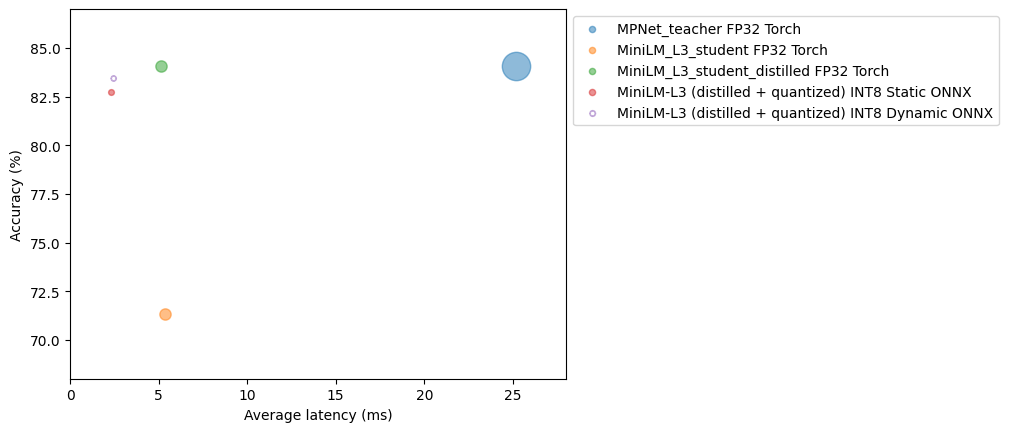

In [17]:
plot_metrics(perf_metrics, optim_type)

In [18]:
print('\n'.join(["{}: {:.2f}%, {:.2f}ms, {:.2f}MB".format(k, perf_metrics[k]['accuracy']*100, perf_metrics[k]['time_avg_ms'], perf_metrics[k]['size_mb']) for k in perf_metrics]))

MPNet_teacher FP32 Torch: 84.05%, 25.16ms, 417.73MB
MiniLM_L3_student FP32 Torch: 71.33%, 5.38ms, 66.36MB
MiniLM_L3_student_distilled FP32 Torch: 84.05%, 5.13ms, 66.36MB
MiniLM-L3 (distilled + quantized) INT8 Static ONNX: 82.76%, 2.29ms, 17.49MB
MiniLM-L3 (distilled + quantized) INT8 Dynamic ONNX: 83.47%, 2.43ms, 17.10MB


## SetFit Model Usage

In [19]:
example_sentence = "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."
predicted_label = setfit_onnx_int8_dynamic_model(example_sentence)
print(f"Given sentence:\n  {example_sentence}")
print(f"Model's prediction on this sentence is:\n  {topics.int2str(predicted_label)[0]}")

Given sentence:
  Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Model's prediction on this sentence is:
  Business
